In [147]:
from scraper.scraper import TokenScraper, MinterTransferScraper
from blockchain.token import Token
from blockchain.account import AccountNode

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import collections
import statistics

import json
from pathlib import Path

In [137]:
def build_graph_from_node(node: AccountNode, graph: nx.DiGraph):
    for child in node.children:
        graph.add_edge(node.address, child.address)
        build_graph_from_node(child, graph)

In [138]:
def serialize_graph(node: AccountNode) -> dict:
    return {
        "address": node.address,
        "children": [serialize_graph(child) for child in node.children]
    }

In [139]:
def save_graph_to_json(root: AccountNode, filename: str):
    serialized = serialize_graph(root)
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(serialized, f, indent=2, ensure_ascii=False)

In [140]:
def deserialize_graph(data: dict[str]) -> dict[AccountNode]:
    node = AccountNode(address=data["address"])
    node.children = [deserialize_graph(i) for i in data["children"]]

    return node

In [141]:
def get_root_from_local(filename: str) -> dict[AccountNode]:
    path = Path().parent / filename
    if path.exists():
        print(f'{filename} found locally')
        
        with open(path) as file:
            data = json.load(file)

        graph = deserialize_graph(data=data)

        return graph
    
    print(f'No {filename} file found')

In [142]:
TOKEN = "FUAfBo2jgks6gB4Z4LfZkqSZgzNucisEHqnNebaRxM1P"
MAX_STEPS = 3

file = f'{TOKEN}_{MAX_STEPS}.json'

root = get_root_from_local(file)
if root is None:
    token = TokenScraper(
        token=Token(address=TOKEN)
    ).get_token_data()

    scraper = MinterTransferScraper(token=token, max_steps=MAX_STEPS)
    scraper.run()

    root = scraper.root

serialized_graph = save_graph_to_json(root, file)

FUAfBo2jgks6gB4Z4LfZkqSZgzNucisEHqnNebaRxM1P_3.json found locally


In [143]:
G = nx.DiGraph()
build_graph_from_node(root, G)

In [144]:
node_list = list(G.nodes())

pos = nx.kamada_kawai_layout(G)  

node_colors = ["skyblue"] * len(node_list)

if root.address in node_list:
    idx = node_list.index(root.address)
    node_colors[idx] = "red"

labels = {}
labels[root.address] = "ROOT"

top_n = 10
degrees = sorted(G.degree(), key=lambda x: x[1], reverse=True)
top_nodes = [addr for (addr, deg) in degrees[:top_n]]
for node in top_nodes:
    if node != root.address:
        labels[node] = node[:6] + "..."

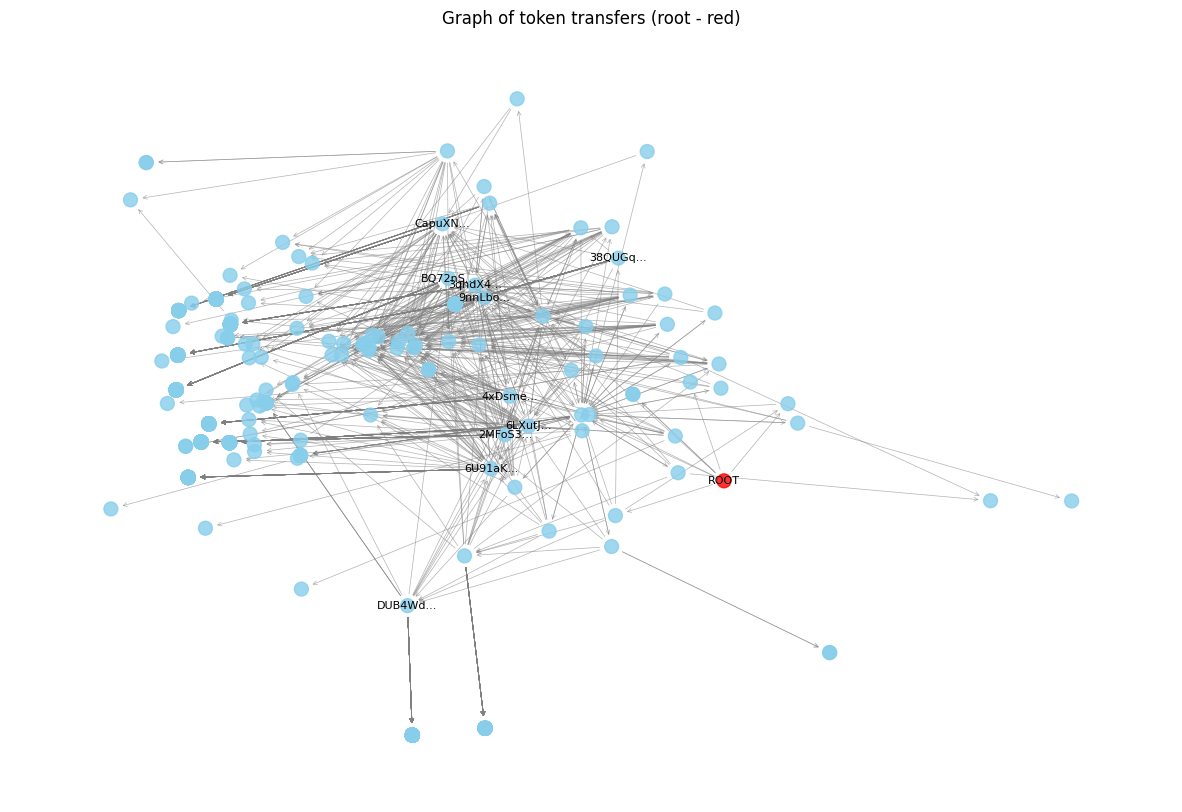

In [145]:
plt.figure(figsize=(15, 10)) 

nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=node_list,
    node_size=100,     
    node_color=node_colors,
    alpha=0.8
)

nx.draw_networkx_labels(
    G,
    pos,
    labels=labels,
    font_size=8
)

nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle="->",
    arrowsize=7,
    width=0.5,   
    alpha=0.6,
    edge_color="gray"
)

plt.title("Graph of token transfers (root - red)")
plt.axis("off")
plt.show()

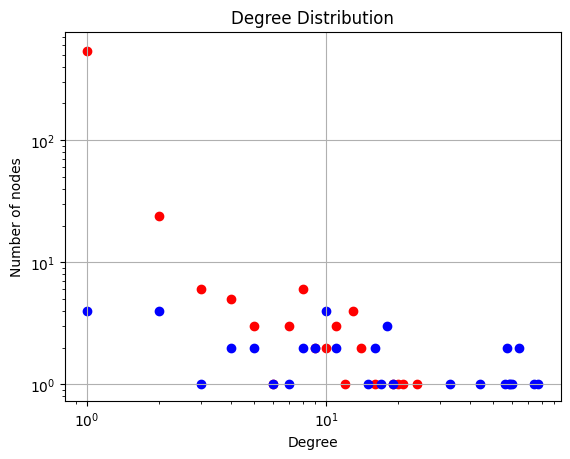

In [146]:
in_deg = [degree for (_, degree) in G.in_degree]
out_deg = [degree for (_, degree) in G.out_degree]

in_degree_count = collections.Counter(in_deg)
out_degree_count = collections.Counter(out_deg)

in_x, in_y = zip(*sorted(in_degree_count.items()))
out_x, out_y = zip(*sorted(out_degree_count.items()))

plt.figure()
plt.scatter(in_x, in_y, c="red") 
plt.scatter(out_x, out_y, c="blue") 

plt.xscale("log")
plt.yscale("log")
plt.grid(True)

plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution")

plt.show()

Средний коэффициент кластеризации (undirected) = 0.0126


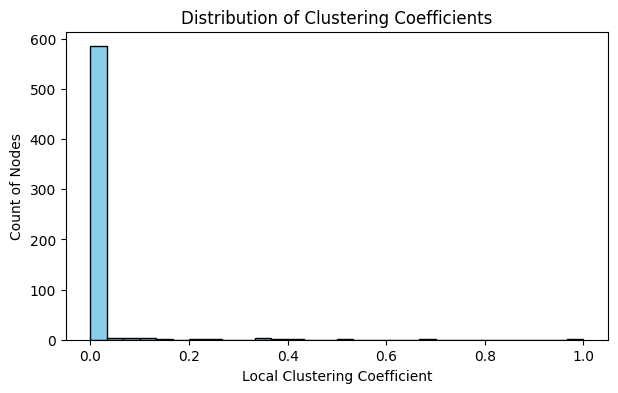

In [148]:
G_und = G.to_undirected()

clustering_dict = nx.clustering(G_und) 

avg_clust = statistics.mean(clustering_dict.values())
print(f"Средний коэффициент кластеризации (undirected) = {avg_clust:.4f}")

plt.figure(figsize=(7, 4))
plt.hist(clustering_dict.values(), bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Local Clustering Coefficient")
plt.ylabel("Count of Nodes")
plt.title("Distribution of Clustering Coefficients")
plt.show()

Avg length of shortesr path = 3.4395


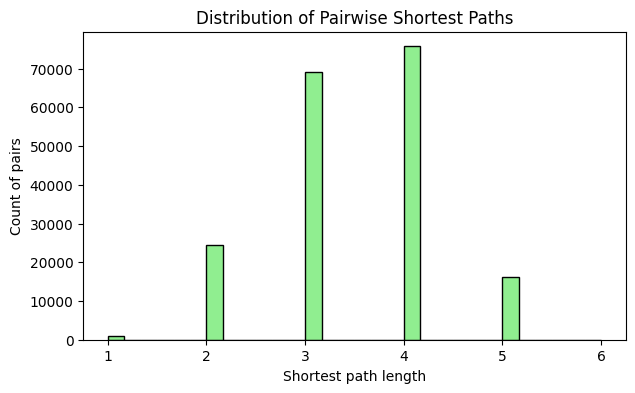

In [150]:
G_und = G.to_undirected()

if not nx.is_connected(G_und):
    components = nx.connected_components(G_und)
    largest_comp = max(components, key=len)
    G_und_sub = G_und.subgraph(largest_comp).copy()
    print("Graph is not connected.")
else:
    G_und_sub = G_und

avg_spl = nx.average_shortest_path_length(G_und_sub)
print(f"Avg length of shortesr path = {avg_spl:.4f}")

distances = []
nodes_sub = list(G_und_sub.nodes())
for i in range(len(nodes_sub)):
    for j in range(i+1, len(nodes_sub)):
        try:
            dist = nx.shortest_path_length(G_und_sub, nodes_sub[i], nodes_sub[j])
            distances.append(dist)
        except nx.NetworkXNoPath:
            pass 

plt.figure(figsize=(7, 4))
plt.hist(distances, bins=30, color="lightgreen", edgecolor="black")
plt.xlabel("Shortest path length")
plt.ylabel("Count of pairs")
plt.title("Distribution of Pairwise Shortest Paths")
plt.show()

Top 5 degree centrality: [('DUB4Wd6ZA2f6ePwDghiPpfWf7Z2eQtqnuaPpPdD6Ebw1', 0.12786885245901639), ('38QUGqkhC3zzEmETBrqbuiyAizVyYJSs5HbzDekJnCDm', 0.12786885245901639), ('3qhdX4gRWJabvcTLSw8UKrqHENF1ZVeXegQnrada6B5B', 0.12459016393442623), ('4xDsmeTWPNjgSVSS1VTfzFq3iHZhp77ffPkAmkZkdu71', 0.12295081967213115), ('BQ72nSv9f3PRyRKCBnHLVrerrv37CYTHm5h3s9VSGQDV', 0.11639344262295082)]
Top 5 betweenness centrality: [('9DiruRpjnAnzhn6ts5HGLouHtJrT1JGsPbXNYCrFz2ad', 0.02146978493636225), ('3qhdX4gRWJabvcTLSw8UKrqHENF1ZVeXegQnrada6B5B', 0.01401244177982091), ('35ZnqaMNCyjYc9ja7bpiE55goiNVYU943A22Bb9YiLdB', 0.010570095439215955), ('CapuXNQoDviLvU1PxFiizLgPNQCxrsag1uMeyk6zLVps', 0.007327711316862315), ('DUB4Wd6ZA2f6ePwDghiPpfWf7Z2eQtqnuaPpPdD6Ebw1', 0.007211276458766787)]
Top 5 closeness centrality: [('AG8znhPJ4m2TJsCX8QvVAPRwr6UJXmCRuecQL8TyM3JQ', 0.04252651880424301), ('3qhdX4gRWJabvcTLSw8UKrqHENF1ZVeXegQnrada6B5B', 0.04087610857296426), ('4VFMMMofu5ntVCqSGFhRqFzXMd12d6eo2FzUYCW4GANg', 0.03857280

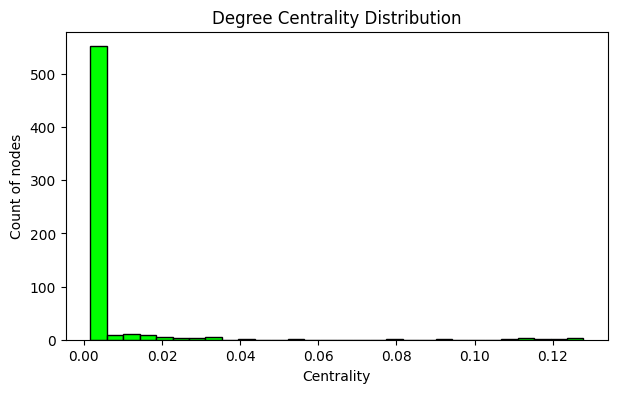

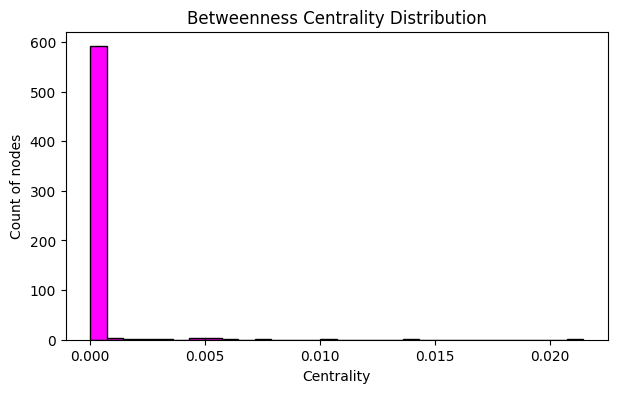

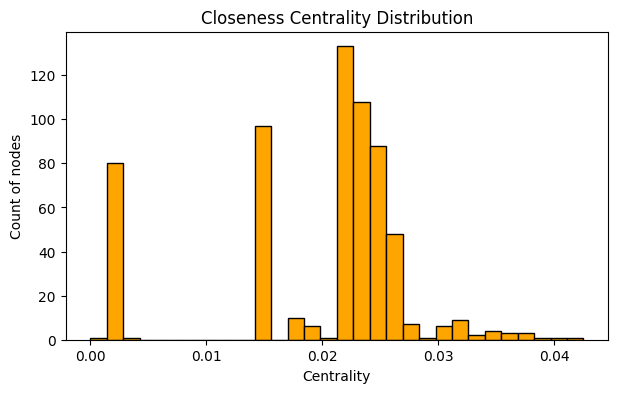

In [153]:
deg_centr = nx.degree_centrality(G)

betw_centr = nx.betweenness_centrality(G)  

close_centr = nx.closeness_centrality(G)

def top5(d: dict):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 degree centrality:", top5(deg_centr))
print("Top 5 betweenness centrality:", top5(betw_centr))
print("Top 5 closeness centrality:", top5(close_centr))

def plot_centrality_hist(values, title, color):
    plt.figure(figsize=(7, 4))
    plt.hist(values, bins=30, color=color, edgecolor="black")
    plt.xlabel("Centrality")
    plt.ylabel("Count of nodes")
    plt.title(title)
    plt.show()

plot_centrality_hist(deg_centr.values(), "Degree Centrality Distribution", "lime")
plot_centrality_hist(betw_centr.values(), "Betweenness Centrality Distribution", "magenta")
plot_centrality_hist(close_centr.values(), "Closeness Centrality Distribution", "orange")